# This notebook serves as the code and solution to the Data Analysis Interview Challenge by Springboard (Ultimate Inc Challenge).

## Part 1 ‐ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15­ minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
Data=pd.read_json('logins.json')

In [3]:
Data.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
Data.shape

(93142, 1)

In [5]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


# The data can best be described as a list of time stamps that indicates a login. All entries are of type datetime64, and no null values are present.

In [6]:
#we check to see if the dates are sorted:

In [7]:
Deltas=[]
for i in range(len(Data)-1):
    Deltas.append(pd.Timedelta(Data.iloc[i+1,0]-Data.iloc[i,0]).total_seconds()/60)

In [8]:
np.min(Deltas)

-29.233333333333334

The data is thus not sorted. We consequently sort it. That will accelerate grouping into 15 minute intervals


In [9]:
Data_sorted=Data.sort_values('login_time')

In [10]:
Deltas=[]
for i in range(len(Data)-1):
    Deltas.append(pd.Timedelta(Data_sorted.iloc[i+1,0]-Data_sorted.iloc[i,0]).total_seconds()/60)

In [11]:
np.min(Deltas)

0.0

In [12]:
np.max(Deltas)
#this seems to be a little bit fishy..Seems like there might be some missing data for a 92 minute period

91.68333333333334

In [13]:
#so the data has been sorted.
#We now set the data as the index and use the time grouper.

In [14]:
Data_sorted.set_index('login_time',drop=False, inplace=True)
Data_grouped=Data_sorted.groupby(pd.TimeGrouper(freq='15Min')).count()
Data_grouped.index.name='Interval_start'
Data_grouped.columns=['Count']

C:\Users\MHarajli\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  


In [15]:
Data_grouped.head()

,Count
Interval_start,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [16]:
#we add a day of the week column to see if there is any weekend vs weekday demand differences
days=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
DayOfTheWeek=[]
for i in range(len(Data_grouped)):
    DayOfTheWeek.append(days[Data_grouped.index[i].weekday()])
Data_grouped['DayOfTheWeek']=DayOfTheWeek

In [17]:
Data_grouped.head()

,Count,DayOfTheWeek
Interval_start,,
1970-01-01 20:00:00,2,Thursday
1970-01-01 20:15:00,6,Thursday
1970-01-01 20:30:00,9,Thursday
1970-01-01 20:45:00,7,Thursday
1970-01-01 21:00:00,1,Thursday


In [18]:
#we see above that the first interval starts at the first of january 1970 at 8 pm.

In [19]:
#we build a plot helper function to highlight time series at weekend days

def highlight(indices,ax):
    i=0
    while i<len(indices)-1:
        if pd.Timedelta(indices[i+1]-indices[i]).total_seconds()/3600/24<1:
            ax.axvspan(indices[i], indices[i+1], facecolor='pink', edgecolor='none', alpha=.2)
        i+=1



Text(0,0.5,'Count')

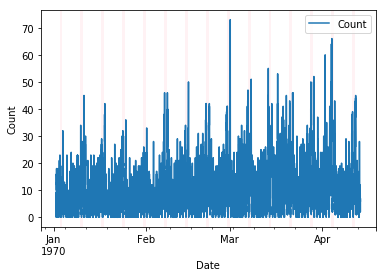

In [20]:
#we plot the login count over the entire Data:
ax=Data_grouped.plot()
highlight(Data_grouped[Data_grouped['DayOfTheWeek']==('Saturday' or 'Sunday')].index,ax)
plt.xlabel('Date')
plt.ylabel('Count')


# Note that the highlighted parts are during the weekends. The first interesting thing we see is a spike in demand at, or right after the weekend. We cannot discuss daily patterns just yet as the above graph is not good enough. We next look at weekly cycles.

Text(0,0.5,'Count')

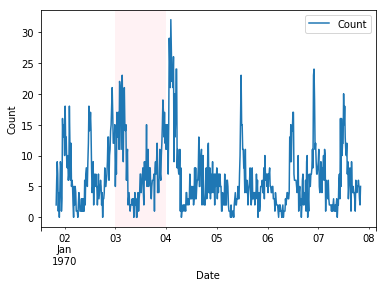

In [21]:
#We look at the first week alone
DF_toplot=Data_grouped['1970-01-01 20:00:00':'1970-01-07 20:00:00']

ax=DF_toplot.plot()
highlight(DF_toplot[DF_toplot['DayOfTheWeek']==('Saturday' or 'Sunday')].index,ax)
plt.xlabel('Date')
plt.ylabel('Count')


Text(0,0.5,'Count')

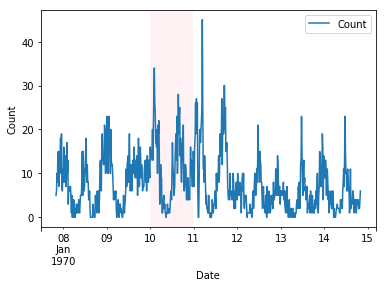

In [22]:
#We check the next week:
DF_toplot=Data_grouped['1970-01-07 20:00:00':'1970-01-14 20:00:00']

ax=DF_toplot.plot()
highlight(DF_toplot[DF_toplot['DayOfTheWeek']==('Saturday' or 'Sunday')].index,ax)
plt.xlabel('Date')
plt.ylabel('Count')


Text(0,0.5,'Count')

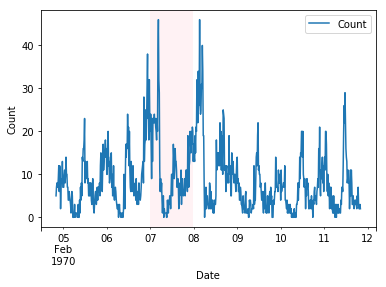

In [23]:
#we then check a random week:
DF_toplot=Data_grouped['1970-02-04 20:00:00':'1970-02-11 20:00:00']

ax=DF_toplot.plot()
highlight(DF_toplot[DF_toplot['DayOfTheWeek']==('Saturday' or 'Sunday')].index,ax)
plt.xlabel('Date')
plt.ylabel('Count')

## From the above we can see that there is infact a surge happening right at the beggining and right after the weekend.

## We next investigate daily cycles by picking a few days and looking at their demand variations.

Index(['Monday', 'Sunday'], dtype='object')


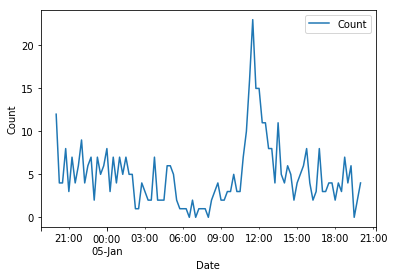

In [24]:
DF_toplot=Data_grouped['1970-01-04 20:00:00':'1970-01-05 20:00:00']

ax=DF_toplot.plot()
#highlight(DF_toplot[DF_toplot['DayOfTheWeek']==('Saturday' or 'Sunday')].index,ax)
plt.xlabel('Date')
plt.ylabel('Count')

print(DF_toplot.DayOfTheWeek.value_counts().index[:])

Index(['Friday', 'Thursday'], dtype='object')


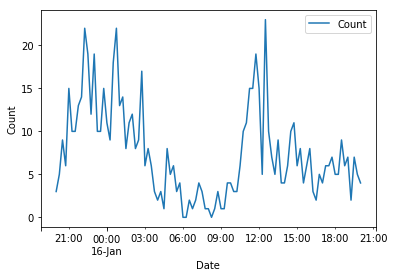

In [25]:
DF_toplot=Data_grouped['1970-01-15 20:00:00':'1970-01-16 20:00:00']

ax=DF_toplot.plot()
#highlight(DF_toplot[DF_toplot['DayOfTheWeek']==('Saturday' or 'Sunday')].index,ax)
plt.xlabel('Date')
plt.ylabel('Count')

print(DF_toplot.DayOfTheWeek.value_counts().index[:])

Index(['Sunday', 'Saturday'], dtype='object')


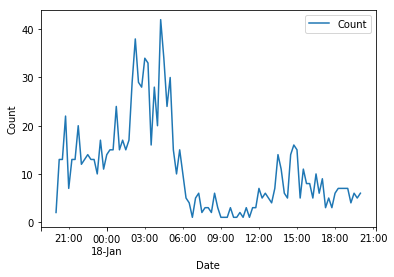

In [26]:
DF_toplot=Data_grouped['1970-01-17 20:00:00':'1970-01-18 20:00:00']

ax=DF_toplot.plot()
#highlight(DF_toplot[DF_toplot['DayOfTheWeek']==('Saturday' or 'Sunday')].index,ax)
plt.xlabel('Date')
plt.ylabel('Count')

print(DF_toplot.DayOfTheWeek.value_counts().index[:])

Index(['Thursday', 'Wednesday'], dtype='object')


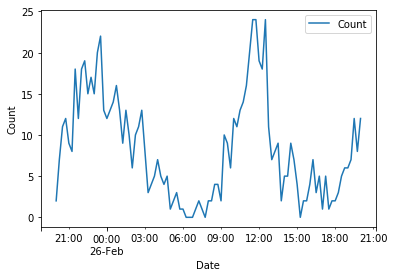

In [27]:
DF_toplot=Data_grouped['1970-02-25 20:00:00':'1970-02-26 20:00:00']

ax=DF_toplot.plot()
#highlight(DF_toplot[DF_toplot['DayOfTheWeek']==('Saturday' or 'Sunday')].index,ax)
plt.xlabel('Date')
plt.ylabel('Count')
print(DF_toplot.DayOfTheWeek.value_counts().index[:])

Index(['Thursday', 'Wednesday'], dtype='object')


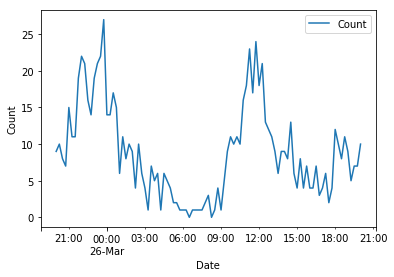

In [28]:
DF_toplot=Data_grouped['1970-03-25 20:00:00':'1970-03-26 20:00:00']

ax=DF_toplot.plot()
#highlight(DF_toplot[DF_toplot['DayOfTheWeek']==('Saturday' or 'Sunday')].index,ax)
plt.xlabel('Date')
plt.ylabel('Count')

print(DF_toplot.DayOfTheWeek.value_counts().index[:])

Index(['Saturday', 'Friday'], dtype='object')


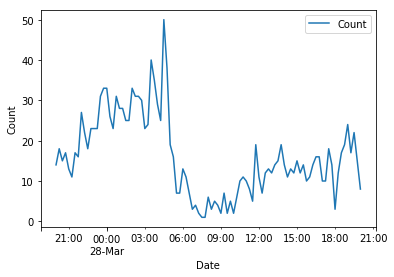

In [29]:
DF_toplot=Data_grouped['1970-03-27 20:00:00':'1970-03-28 20:00:00']

ax=DF_toplot.plot()
#highlight(DF_toplot[DF_toplot['DayOfTheWeek']==('Saturday' or 'Sunday')].index,ax)
plt.xlabel('Date')
plt.ylabel('Count')

print(DF_toplot.DayOfTheWeek.value_counts().index[:])

In [37]:
# Next we look into grouping Date-With Day of the week, and getting average counts over each day of the week.
time=[]
for i in range(len(Data_grouped)):
    time.append(Data_grouped.index[i].time())

Data_grouped['Time']=time


#Next We group by DayOfTheWeek and Time

,Count,DayOfTheWeek,Time
Interval_start,,,
1970-01-01 20:00:00,2,Thursday,20:00:00
1970-01-01 20:15:00,6,Thursday,20:15:00
1970-01-01 20:30:00,9,Thursday,20:30:00
1970-01-01 20:45:00,7,Thursday,20:45:00
1970-01-01 21:00:00,1,Thursday,21:00:00
1970-01-01 21:15:00,4,Thursday,21:15:00
1970-01-01 21:30:00,0,Thursday,21:30:00
1970-01-01 21:45:00,4,Thursday,21:45:00
1970-01-01 22:00:00,9,Thursday,22:00:00


In [60]:
AverageOverDay=Data_grouped.groupby(['DayOfTheWeek','Time']).Count.agg(['mean','std'])

day=[]
upperBound=[]
lowerBound=[]
for i in range(len(AverageOverDay)):
    day.append(AverageOverDay.index[i][0])
    upperBound.append(AverageOverDay['mean'][i]+AverageOverDay['std'][i])
    lowerBound.append(AverageOverDay['mean'][i]-AverageOverDay['std'][i])
    
AverageOverDay['Upper']=upperBound
AverageOverDay['Lower']=lowerBound
AverageOverDay['DOW']=day
AverageOverDay.head()

mean       std      Upper      Lower     DOW
DayOfTheWeek Time                                                       
Friday       00:00:00  15.800000  7.282072  23.082072   8.517928  Friday
             00:15:00  17.533333  5.139020  22.672353  12.394314  Friday
             00:30:00  15.466667  5.180550  20.647216  10.286117  Friday
             00:45:00  16.200000  5.479833  21.679833  10.720167  Friday
             01:00:00  17.266667  6.385997  23.652663  10.880670  Friday

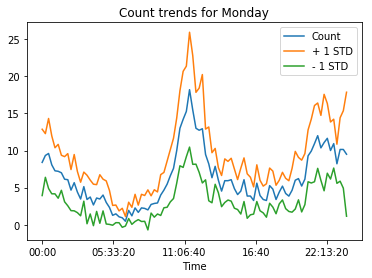

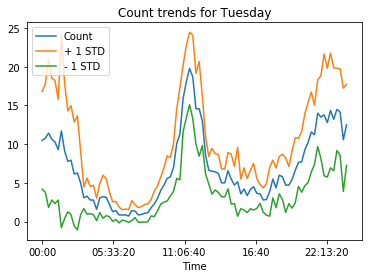

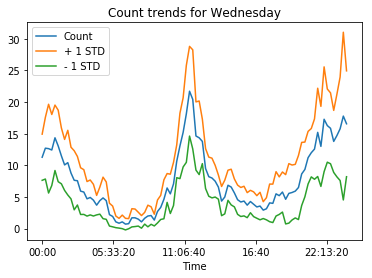

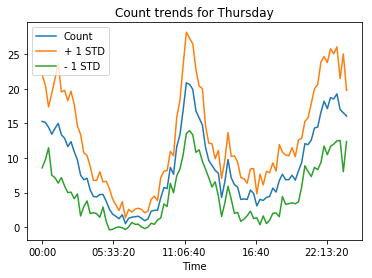

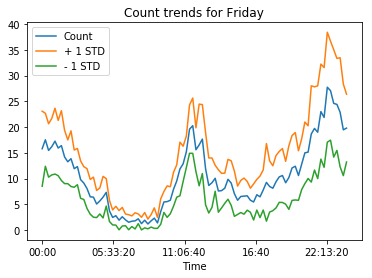

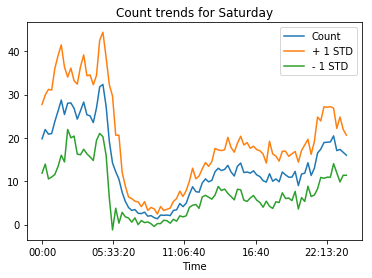

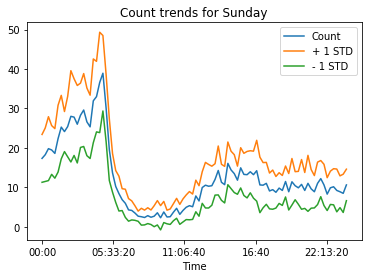

In [78]:
#plot for each day:
for day in days:
    ax=AverageOverDay[AverageOverDay['DOW']==day].unstack(level=0)['mean'].plot()
    AverageOverDay[AverageOverDay['DOW']==day].unstack(level=0)['Upper'].plot(ax=ax)
    AverageOverDay[AverageOverDay['DOW']==day].unstack(level=0)['Lower'].plot(ax=ax)
    ax.set_title('Count trends for {}'.format(day))
    ax.legend(['Count','+ 1 STD','- 1 STD'])


## Question Solution:

In the above, we loaded the json file as a pandas dataframe, sorted it, finally grouping logins into 15 minute intervals and providing the count for each interval.

We next plotted the login counts through time, first looking at the variation throughtout the entire data set, then through a select few weeks, finally through select 24 hour periods.

The main takeaways are:

1- There seems to be a surge in logins just at the beggining of the weekends and just after.

2- For days of the week, logins seems to peak at noon and midnight.

3- Fridays: logins keep increasing and peak at around 3 am the next day.

4- Saturdays, The logins keep increasing all day and surge at around 3 am the next day.

5- Sundays, logins are steady, with a decrease in the late pm's



## Part 2 ‐ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two ­way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:

    a. how you will implement the experiment

    b. what statistical test(s) you will conduct to verify the significance of the
    observation

    c. how you would interpret the results and provide recommendations to the city
    operations team along with any caveats.

# Solution:

At the moment, driver partners are exclusive to one city as to avoid toll costs.

We define trip origin as:

Trip Origin: The location of the start of a trip where the driver picked up a customer.


For a 24 hour period, a driver serving both cities can be defined as one who has trip origins in both cities. Of course, this definition can be tweaked depending on what the goal of the experiment is (we could say that a driver served both cities if the ratio of trip origins in city A to city B is close to 1). 

## Solution To Question 1: The propotion of drivers serving both cities will be the key metric used to evaluate how successfull the experiment is.

With a measure of success we now design our experiment.



## Solution to Question 2:

The experiment duration is picked. For example the 24 hour period from 12:01 am till 11:59 pm for a given Wednesday.

Let N be the total number of operational drivers Ultimate Inc has. 

Let n_test << N with n_test>50 drivers.

Inform n_test drivers that they will be eligible for the reimbursement on the given experiment day.

The remaining n_control drivers will not be offered the reimbursement. n_control can either be N-n_test or just a small pool of representative drivers Ultimate Inc has access to data for. Of course the bigger the number the better.


This way we have a control group (those who did not get the reimbursement option) and a test group (those who did), who have all the conditions similar except for the option of reimbursement.

Calling sb_control: the number of drivers in the control group that served both cities.

p_control: the proportion of drivers in the control group that served both cities=sb_control/n_control

sb_test: the number of drivers in the test group that served both cities.

p_test: the proportion of drivers in the test group that served both cities=sb_test/n_test

p=(sb_test+sb_control)/(n_test+n_control)

We set our null hypothesis H0: p_test=p_control and alternate hypothesis Ha as p_test>p_control

We set a significance Level (say 0.05).

A z statistics can then be calculated for the difference observed (assuming we get sample sizes that are representative).

The z-statistic can be computed as: (p_control-p_test)/sqrt(A)

Where A=p(1-p)((1/n_test)+(1/n_control))

If the z-statistic exceeds the allowed value under the significance level chosen, the null hypothesis is rejected, and the alternate accepted.

The significance Level would have to be discussed in detail, as it plays a major role in the interpretation of results. I would explain that a significance level is inversely proportional to how certain we want to be that the difference between the proprotions is true. 










In [60]:
##Question 3:

## Part 3 ‐ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account inJanuary 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to

improve its long­ term rider retention (again, a few sentences will suffice).

In [105]:
#we begin with loading the data:
import json
with open('ultimate_data_challenge.json') as file:
    Data=json.load(file)
    
Data_DF=pd.DataFrame(Data)
Data_DF.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [106]:
Data_DF.shape
#We have the information for 50000 users.
#for each user we have 12 features.

(50000, 12)

In [107]:
Data_DF.info()
#we see that some of the features are null for some entries. 
#(e.g. only 41878 of the riders have an avg_rating_of_driver)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [108]:
#for the numerical features we get some statistics:
Data_DF.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [109]:
#next we change the time columns into type datetime.
Data_DF['last_trip_date']=pd.to_datetime(Data_DF['last_trip_date'])
Data_DF['signup_date']=pd.to_datetime(Data_DF['signup_date'])
Data_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


In [130]:
#We check to see if all users in this data set infact signed up in january:
print('The earliest sign up date is: {}'.format(str(Data_DF.signup_date.min().date())))
print('The latest sign up date is: {}'.format(str(Data_DF.signup_date.max().date())))

#all sign ups happen in january

The earliest sign up date is: 2014-01-01
The latest sign up date is: 2014-01-31


In [131]:
#We assume that the last day any of the riders had a ride is the day this information was obtained.
#From LastRecordingDate, we can go back 30 days to check if riders have been retained.
LastRecordingDate=Data_DF.last_trip_date.max()
print(LastRecordingDate.date())

2014-07-01


In [132]:
retained=[]
for i in range(len(Data_DF)):
    #we check if the user was active within 30 days from the day this data set was obtained
    if pd.Timedelta(LastRecordingDate-Data_DF['last_trip_date'][i]).days<30:
        retained.append(1)
    else:
        retained.append(0)

#we add a column indicating if retained (1) or not (0)
Data_DF['retained']=retained

In [133]:
Data_DF.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,retained
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084,0.36620
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503,0.48177
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000,0.00000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000,0.00000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000,1.00000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000,1.00000


In [ ]:
#as can be seen 36.6% of people who signed up on january first were retained.

## Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.